<a href="https://colab.research.google.com/github/Fu-Pei-Yin/Deep-Generative-Mode/blob/week2/GAN%E5%9C%A8%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97%E4%B8%8A%E7%9A%84%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
Starting Training Loop...
Epoch: 1/50 [0/60000 (0%)]
Epoch: 1/50 [12800/60000 (21%)]
Epoch: 1/50 [25600/60000 (43%)]
Epoch: 1/50 [38400/60000 (64%)]
Epoch: 1/50 [51200/60000 (85%)]
[1/50]: loss_d: 0.830, loss_g: 1.868
Epoch: 2/50 [0/60000 (0%)]
Epoch: 2/50 [12800/60000 (21%)]
Epoch: 2/50 [25600/60000 (43%)]
Epoch: 2/50 [38400/60000 (64%)]
Epoch: 2/50 [51200/60000 (85%)]
[2/50]: loss_d: 0.620, loss_g: 3.083
Epoch: 3/50 [0/60000 (0%)]
Epoch: 3/50 [12800/60000 (21%)]
Epoch: 3/50 [25600/60000 (43%)]
Epoch: 3/50 [38400/60000 (64%)]
Epoch: 3/50 [51200/60000 (85%)]
[3/50]: loss_d: 0.564, loss_g: 2.971
Epoch: 4/50 [0/60000 (0%)]
Epoch: 4/50 [12800/60000 (21%)]
Epoch: 4/50 [25600/60000 (43%)]
Epoch: 4/50 [38400/60000 (64%)]
Epoch: 4/50 [51200/60000 (85%)]
[4/50]: loss_d: 0.506, loss_g: 3.181
Epoch: 5/50 [0/60000 (0%)]
Epoch: 5/50 [12800/60000 (21%)]
Epoch: 5/50 [25600/60000 (43%)]
Epoch: 5/50 [38400/60000 (64%)]
Epoch: 5/50 [51200/60000 (85%)]
[5/50]: loss_d: 0.563, loss_g: 2.

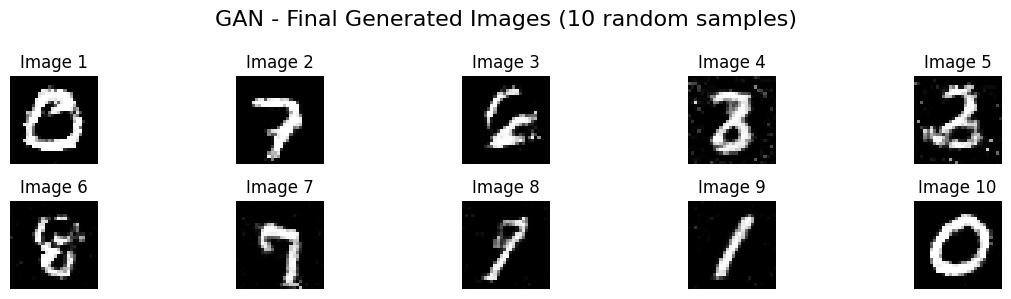

/tmp/ipython-input-2352803189.py:244: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img_name))


All done! Results saved in MNIST_GAN_results folder.
Final 10 generated images saved as 'GAN_final_10_images.png'


In [5]:
import os
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import random

# 固定隨機種子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 檢查是否有GPU可用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# G(z)
class generator(nn.Module):
    def __init__(self, input_size=100, n_class=28*28):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 1024)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        return x

class discriminator(nn.Module):
    def __init__(self, input_size=28*28, n_class=1):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, 256)
        self.fc4 = nn.Linear(self.fc3.out_features, n_class)

    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc4(x))
        return x

# 固定噪聲用於生成可比較的圖像
fixed_z_ = torch.randn((10, 100)).to(device)  # 改為10張用於最終輸出

def show_result(num_epoch, show=False, save=False, path='result.png', isFix=False):
    if isFix:
        z_ = fixed_z_
    else:
        z_ = torch.randn((10, 100)).to(device)  # 生成10張影像

    G.eval()
    with torch.no_grad():
        test_images = G(z_)
    G.train()

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.ravel()

    for i in range(10):
        axes[i].imshow(test_images[i, :].cpu().view(28, 28).numpy(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle(f'Epoch {num_epoch}', fontsize=16)
    plt.tight_layout()

    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['D_losses']))

    plt.figure(figsize=(10, 5))
    plt.plot(x, hist['D_losses'], label='Discriminator Loss')
    plt.plot(x, hist['G_losses'], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss History')
    plt.grid(True)

    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

# training parameters
batch_size = 128
lr = 2e-4  # 符合要求的學習率
train_epoch = 50 # 符合要求的訓練週期

# data_loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

# network
G = generator(input_size=100, n_class=28*28).to(device)
D = discriminator(input_size=28*28, n_class=1).to(device)

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# results save folder
if not os.path.isdir('MNIST_GAN_results'):
    os.mkdir('MNIST_GAN_results')
if not os.path.isdir('MNIST_GAN_results/Random_results'):
    os.mkdir('MNIST_GAN_results/Random_results')
if not os.path.isdir('MNIST_GAN_results/Fixed_results'):
    os.mkdir('MNIST_GAN_results/Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

print("Starting Training Loop...")
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []

    for batch_idx, (x_, _) in enumerate(train_loader):
        # train discriminator D
        D.zero_grad()

        x_ = x_.view(-1, 28 * 28).to(device)
        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch, 1).to(device)
        y_fake_ = torch.zeros(mini_batch, 1).to(device)

        # Discriminator real loss
        D_result = D(x_)
        D_real_loss = BCE_loss(D_result, y_real_)

        # Discriminator fake loss
        z_ = torch.randn((mini_batch, 100)).to(device)
        G_result = G(z_)
        D_result = D(G_result)
        D_fake_loss = BCE_loss(D_result, y_fake_)

        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).to(device)
        G_result = G(z_)
        D_result = D(G_result)
        G_train_loss = BCE_loss(D_result, y_real_)  # 讓生成器生成的圖片被判斷為真

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch+1}/{train_epoch} [{batch_idx * len(x_)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]')

    avg_D_loss = torch.mean(torch.FloatTensor(D_losses)).item()
    avg_G_loss = torch.mean(torch.FloatTensor(G_losses)).item()

    print(f'[{epoch+1}/{train_epoch}]: loss_d: {avg_D_loss:.3f}, loss_g: {avg_G_loss:.3f}')

    # 保存結果
    p = f'MNIST_GAN_results/Random_results/MNIST_GAN_{epoch+1}.png'
    fixed_p = f'MNIST_GAN_results/Fixed_results/MNIST_GAN_{epoch+1}.png'
    show_result((epoch+1), save=True, path=p, isFix=False)
    show_result((epoch+1), save=True, path=fixed_p, isFix=True)

    train_hist['D_losses'].append(avg_D_loss)
    train_hist['G_losses'].append(avg_G_loss)

print("Training finish!... save training results")
torch.save(G.state_dict(), "MNIST_GAN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_GAN_results/discriminator_param.pkl")

with open('MNIST_GAN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path='MNIST_GAN_results/MNIST_GAN_train_hist.png')

# 生成最終的10張隨機影像（符合作業要求）
print("Generating final 10 random images...")
final_z = torch.randn((10, 100)).to(device)
G.eval()
with torch.no_grad():
    final_images = G(final_z)

plt.figure(figsize=(12, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(final_images[i, :].cpu().view(28, 28).numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1}')
plt.suptitle('GAN - Final Generated Images (10 random samples)', fontsize=16)
plt.tight_layout()
plt.savefig('MNIST_GAN_results/GAN_final_10_images.png')
plt.show()

# 生成動畫
images = []
for e in range(min(train_epoch, 30)):  # 最多30個epoch的動畫
    img_name = f'MNIST_GAN_results/Fixed_results/MNIST_GAN_{e+1}.png'
    if os.path.exists(img_name):
        images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_GAN_results/generation_animation.gif', images, fps=5)

print("All done! Results saved in MNIST_GAN_results folder.")
print("Final 10 generated images saved as 'GAN_final_10_images.png'")